In [6]:
# Download the image paths and labels

!wget -qnc https://www.chronophoto.app/badSneakers.txt

In [7]:
import json

with open("badSneakers.txt", 'r') as f:
    urls = json.load(f)

print(urls["1900"][0])

www.chronophoto.app/katylies/1900/1.jpeg


In [1]:
# Download and unzip dataset.
!gdown 1sOL-Rut8WQa1jmBCaUK7QCtMu0DoVeBu
!unzip chronophoto
!rm chronophoto.zip

# Download label JSON.
!gdown 1QXuhWiGse0deIEoPKxVTxZ9uIJZCEt_Q
!mv labels.json chronophoto/

Streaming output truncated to the last 5000 lines.
  inflating: chronophoto/1994_40.JPEG  
  inflating: __MACOSX/chronophoto/._1994_40.JPEG  
  inflating: chronophoto/2006_13.JPEG  
  inflating: __MACOSX/chronophoto/._2006_13.JPEG  
  inflating: chronophoto/1910_10.JPEG  
  inflating: __MACOSX/chronophoto/._1910_10.JPEG  
  inflating: chronophoto/1948_1.JPEG  
  inflating: __MACOSX/chronophoto/._1948_1.JPEG  
  inflating: chronophoto/2012_50.JPEG  
  inflating: __MACOSX/chronophoto/._2012_50.JPEG  
  inflating: chronophoto/1943_22.JPEG  
  inflating: __MACOSX/chronophoto/._1943_22.JPEG  
  inflating: chronophoto/1904_53.JPEG  
  inflating: __MACOSX/chronophoto/._1904_53.JPEG  
  inflating: chronophoto/1900_10.JPEG  
  inflating: __MACOSX/chronophoto/._1900_10.JPEG  
  inflating: chronophoto/2016_13.JPEG  
  inflating: __MACOSX/chronophoto/._2016_13.JPEG  
  inflating: chronophoto/1947_61.JPEG  
  inflating: __MACOSX/chronophoto/._1947_61.JPEG  
  inflating: chronophoto/2012_3.JPEG  
  

Image taken in 1900.


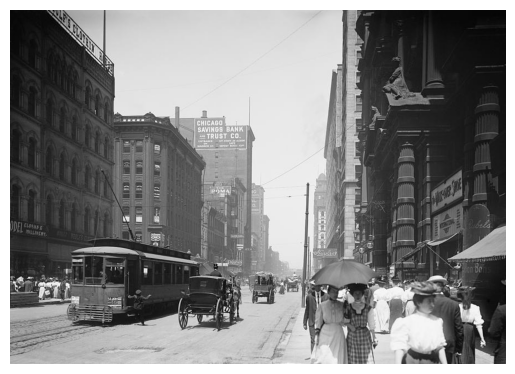

In [29]:
import torch 
from PIL import Image
import matplotlib.pyplot as plt

class ChronoPhoto(torch.utils.data.Dataset):

    def __init__(self, transform=None, use_rgb=True):
        with open("chronophoto/labels.json", 'r') as f:
            path2label = json.load(f)
        
        self.folder = "chronophoto"
        self.transform = transform
        self.use_rgb = use_rgb
        self.categories = range(1900,2022)

        self.imagepaths = []
        self.labels = []
        for path, label in path2label.items():
            self.imagepaths.append(self.folder + '/' + path)
            self.labels.append(label)
        
    def __getitem__(self, index):
        image = Image.open(self.imagepaths[index])
        if self.use_rgb:
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[index]

    def __len__(self):
        return len(self.labels)


test = ChronoPhoto()
img, label = test[1]
print(f"Image taken in {label}.")

plt.figure();plt.imshow(img);
plt.grid(False); plt.axis('off'); plt.show()


## (1) Zero Shot Labeling w/ CLIP (Image -> Year)


```
# This is formatted as code
```



In [10]:
# Download Model and required packages
# SOURCE: https://github.com/openai/CLIP
# Importing relevant features and loading the model

!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import os
import clip
import torch
import random

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)




/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hewfljt6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hewfljt6
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


Actual Year: 1931
Guessed Year: 1943


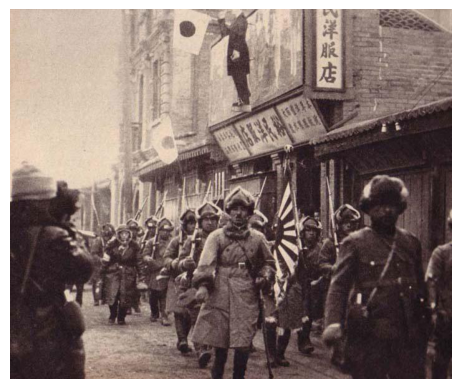

Scored 242 on image: 1887
###################################
Actual Year: 1931
Guessed Year: 1936


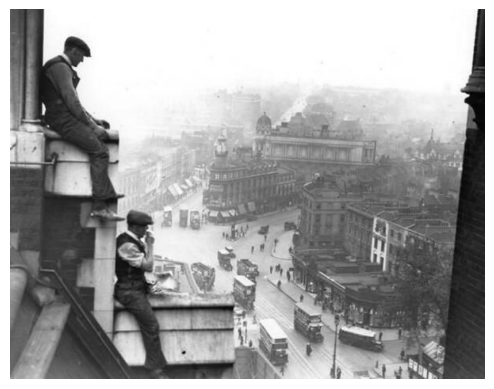

Scored 640 on image: 1891
###################################
Actual Year: 1920
Guessed Year: 1914


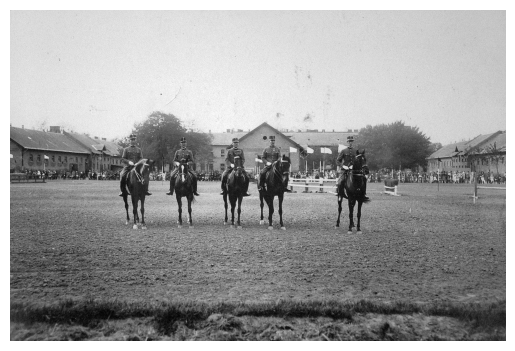

Scored 575 on image: 1298
###################################
Actual Year: 1963
Guessed Year: 1969


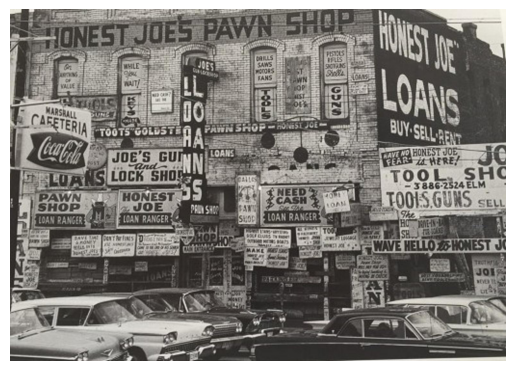

Scored 575 on image: 4021
###################################
Actual Year: 1963
Guessed Year: 1970


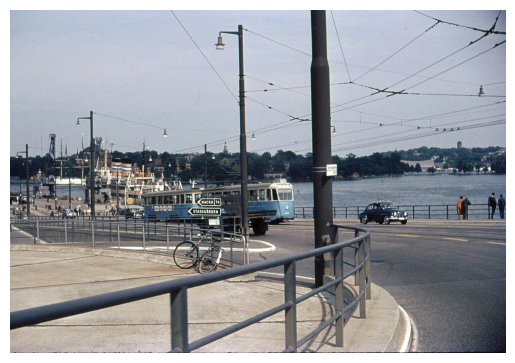

Scored 513 on image: 4053
###################################
Output Accuracy: 254.5000


In [48]:
def calculateScore(realYear, inputYear):

    pictureDate = realYear
    guessedDate = inputYear
    
    dif = abs(pictureDate - guessedDate)
    
    if(dif <= 20):
        return round(((20 - dif)**1.55) * 9.62506135768)
    else:
        return 0

def processImage(id, dataset, top_n):
    # n_correct = 0

    # No masks required because we are not performing any tokenizing
    image, label = dataset[id]
    image_input = preprocess(image).unsqueeze(0).to(device)

    text_inputs = torch.cat([clip.tokenize(f"A photo taken in the year {c}") for c in dataset.categories]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

        logits_per_image, logits_per_text = model(image_input, text_inputs)

        similiarity = logits_per_image.softmax(dim = -1)

        values, indices = similiarity.topk(top_n)
        # print(values)
    
    # print(indices)
    # print(indices[0].item())
    # print(indices[1].item())
    # print(indices[2].item())
    print(f'Actual Year: {label}')

    outputYear = 1900 + indices[0].item()
    print(f'Guessed Year: {outputYear}')


    score = calculateScore(label, outputYear);
    #   What we were doing in assignment 2
    #   if indices[0].item() == label:
    #     n_correct += 1

    return score

def run_clip_on_data(dataset, num_samples, top_n):
  
  cumulativeScore = 0
  curr_score = 0
  samples_to_eval = []
  
  for i in range(num_samples):
    # FILL IN WITH LENGTH OF DATASET
    samples_to_eval.append(random.randrange(5000))

  model.eval()

  for id in samples_to_eval:

    # Chooses the top '1' most probable category.
    curr_score = processImage(id, dataset, top_n)    

    img, label = test[id]
    # print(f"Image taken in {label}.")

    plt.figure();plt.imshow(img);
    plt.grid(False); plt.axis('off'); plt.show()

    print(f'Scored {curr_score} on image: {id}')
    print('###################################')
    cumulativeScore += curr_score
    num_samples += 1 

  print('Output Accuracy: {:.4f}'.format(cumulativeScore / num_samples))


# Create Dataset
inputSet = ChronoPhoto()
img, label = inputSet[1]

# run_clip_on_data(valset, len(valset));
run_clip_on_data(inputSet, 5, top_n = 1);


